In [1]:
import sys
sys.path.append('../')
from megaparse.cdp.utils.diff_agent import DifferenceAgent, ContextType
from megaparse.cdp.utils.query_engine import get_query_engine
from pathlib import Path
from megaparse.cdp.utils.question_generator import QuestionGenerator

In [2]:
query_engine = get_query_engine(Path("../megaparse/cdp/CDP_QUAL_CHART_01_CHARTE_PRODUITS.md"))
question_generator = QuestionGenerator()

In [3]:
agent = DifferenceAgent(query_engine, document_context= None, question_generator=question_generator)


In [4]:
questions = agent.generate_questions(Path("../megaparse/cdp/exemple_fournisseur_palet.xlsx"), tab_name = 'Fiche recette', language_verification= True)

Generating Questions ...
Verifying language and translating questions ...


In [ ]:
# additional_context = ContextType(category='Entree de Gamme', context='pour les produits de la catégorie Entree de Gamme ?')
# agent.run(additional_context=additional_context, verbose=True)

In [5]:
additional_contexts = [ContextType(category='Entree de Gamme', context='pour les produits de la catégorie Entree de Gamme ?'),
                        ContextType(category='Coeur de Gamme', context='pour les produits de la catégorie Coeur de Gamme ?'),
                        ContextType(category='Haut de Gamme', context='pour les produits de la catégorie Haut de Gamme ?')]
generated_df = agent.evaluate(source_path= None, target_path= Path('../megaparse/cdp/ground_truth_palet.csv'), tab_name= None, additional_contexts=additional_contexts, verbose=True)


Querying generated questions to the reference document...


100%|██████████| 27/27 [01:21<00:00,  3.02s/it]


Querying generated questions to the reference document...


100%|██████████| 27/27 [01:21<00:00,  3.03s/it]


Querying generated questions to the reference document...


 78%|███████▊  | 21/27 [01:03<00:17,  2.87s/it]

Error with question: - "Sirop de sucre inverti cristallisé" utilisé dans la trimoline est-il conforme aux exigences ?
Retry ...
Error with question: - "Sirop de sucre inverti cristallisé" utilisé dans la trimoline est-il conforme aux exigences ?
Retry ...


100%|██████████| 27/27 [01:24<00:00,  3.12s/it]


no match found for:  crme strilis uht 35
no match found for:  poudre de cacao
no match found for:  poudre damandes


ValueError: Found input variables with inconsistent numbers of samples: [20, 22]

In [42]:
import pandas as pd
import difflib
import re
def clean_name(name):
            name = name.lower()
            name = re.sub(r'[^a-z0-9\s]', '', name)
            name = re.sub(r'\s+', ' ', name)
            
            return name.strip()
def fuzzy_match(name, choices, threshold=0.8):
            matches = [g_name for g_name in choices if name in g_name]
            if matches:
                return matches
            
            matches = difflib.get_close_matches(name, choices, n=1, cutoff=threshold)
            if matches:
                return matches
            else:
                return None
generated_df = agent.generated_df
target_df = pd.read_csv(Path('../megaparse/cdp/ground_truth_palet.csv'))
target_df['cleaned_name'] = target_df['name'].apply(clean_name)

matched_rows = []
target_df_copy = target_df.copy()

for target_name in target_df['cleaned_name']:
    matched_name = fuzzy_match(target_name, generated_df['cleaned_name'])
    if matched_name:
        matched_row = generated_df.loc[generated_df['cleaned_name'] == matched_name[0]].copy()
        if len(matched_row)>1:
            matched_row = matched_row.iloc[0:1]
        matched_row['cleaned_name'] = target_name
        matched_rows.append(matched_row)
    else:
        print("no match found for: ", target_name)
        target_df_copy = target_df_copy[target_df_copy['cleaned_name'] != target_name]
        
target_df_copy.reset_index(drop=True, inplace=True)
matched_gen_df = None    
# Create the matched_generated_df DataFrame from the list of matched rows
if matched_rows:
    matched_gen_df = pd.concat(matched_rows, ignore_index=True)
else:
    matched_gen_df = pd.DataFrame(columns=generated_df.columns)

matched_gen_df = matched_gen_df.drop(columns = [c_name for c_name in matched_gen_df.columns if 'detail' in c_name])


no match found for:  crme strilis uht 35
no match found for:  poudre de cacao
no match found for:  poudre damandes


In [48]:
agent.generated_df

,name,Entree de Gamme.0,Entree de Gamme.0.detail,Coeur de Gamme.0,Coeur de Gamme.0.detail,Haut de Gamme.0,Haut de Gamme.0.detail,cleaned_name
0,LAIT de chèvre pasteurisé,DecisionEnum.authorized,Le lait de chèvre pasteurisé est autorisé pour...,DecisionEnum.authorized,Le lait de chèvre pasteurisé est un ingrédient...,DecisionEnum.authorized,Le lait de chèvre pasteurisé est conforme aux ...,lait de chvre pasteuris
1,Sel,DecisionEnum.authorized,Le sel est un ingrédient couramment utilisé da...,DecisionEnum.authorized,Le sel est un ingrédient couramment utilisé da...,DecisionEnum.authorized,Le sel est un ingrédient couramment utilisé da...,sel
2,Ferments,DecisionEnum.authorized,Les ferments utilisés dans le fromage de chèvr...,DecisionEnum.authorized,Les ferments utilisés dans le fromage de chèvr...,DecisionEnum.authorized,Les ferments utilisés dans le fromage de chèvr...,ferments
3,Crème,DecisionEnum.authorized,La crème est un produit laitier obtenu par écr...,DecisionEnum.authorized,La crème est un produit laitier obtenu par écr...,DecisionEnum.authorized,La crème est un produit laitier obtenu par écr...,crme
4,Carraghénanes,DecisionEnum.authorized,Les carraghénanes sont des polysaccharides ext...,DecisionEnum.authorized,Les carraghénanes sont des additifs alimentair...,DecisionEnum.forbidden,Les carraghénanes sont des polysaccharides ext...,carraghnanes
5,Beurre doux,DecisionEnum.authorized,Le beurre doux est un produit laitier naturel ...,DecisionEnum.authorized,Le beurre doux est un produit laitier naturel ...,DecisionEnum.authorized,Le beurre doux est un produit laitier naturel ...,beurre doux
6,Abricot sec,DecisionEnum.authorized,Les abricots secs sont généralement conformes ...,DecisionEnum.authorized,Les abricots secs sont des fruits déshydratés ...,DecisionEnum.authorized,Les abricots secs sont généralement conformes ...,abricot sec
7,Anhydride sulfureux (E220),DecisionEnum.to_avoid,Anhydride sulfureux (E220) is listed in Annex ...,DecisionEnum.to_avoid,Anhydride sulfureux (E220) is listed in Annex ...,DecisionEnum.to_avoid,Anhydride sulfureux (E220) is listed in Annex ...,anhydride sulfureux e220
8,Eau,DecisionEnum.authorized,L'eau est un ingrédient de base et ne contient...,DecisionEnum.authorized,L'eau est un ingrédient de base et ne contient...,DecisionEnum.authorized,L'eau est un ingrédient de base et ne figure p...,eau
9,Vinaigre de vin blanc,DecisionEnum.authorized,Le vinaigre de vin blanc est un ingrédient sim...,DecisionEnum.authorized,Le vinaigre de vin blanc est un ingrédient cou...,DecisionEnum.authorized,Le vinaigre de vin blanc est un ingrédient cou...,vinaigre de vin blanc


In [44]:
target_df

,name,Entree de Gamme,Coeur de Gamme,Haut de Gamme,cleaned_name
0,lait de chèvre pasteurisé,Authorized,Authorized,Authorized,lait de chvre pasteuris
1,sel,Authorized,Authorized,Authorized,sel
2,farine de blé,Authorized,Authorized,Authorized,farine de bl
3,beurre doux,Authorized,Authorized,Authorized,beurre doux
4,crème stérilisé UHT 35%,Authorized,Authorized,Authorized,crme strilis uht 35
5,carraghénanes,To Avoid,To Avoid,To Avoid,carraghnanes
6,abricot sec,Authorized,Authorized,Authorized,abricot sec
7,E220,To Avoid,To Avoid,To Avoid,e220
8,eau,Authorized,Authorized,Authorized,eau
9,poudre de cacao,Authorized,Authorized,Authorized,poudre de cacao


In [45]:
metrics, overall_metrics = agent.compute_metrics(target_df_copy, matched_gen_df)

List of errors by category : 

Errors for Entree de Gamme:
carraghnanes: 1 errors
oeuf entier: 1 errors
mtabisulfite de potassium: 1 errors
saccharose: 1 errors
e341: 1 errors

Errors for Coeur de Gamme:
carraghnanes: 1 errors
oeuf entier: 1 errors
mtabisulfite de potassium: 1 errors
e450: 1 errors

Errors for Haut de Gamme:
carraghnanes: 1 errors
oeuf entier: 1 errors
sirop de sucre inverti cristallis: 1 errors


/Users/chloed./.local/share/virtualenvs/MegaParse-onLGVT8Y/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chloed./.local/share/virtualenvs/MegaParse-onLGVT8Y/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chloed./.local/share/virtualenvs/MegaParse-onLGVT8Y/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t


Metrics for Entree de Gamme.0:


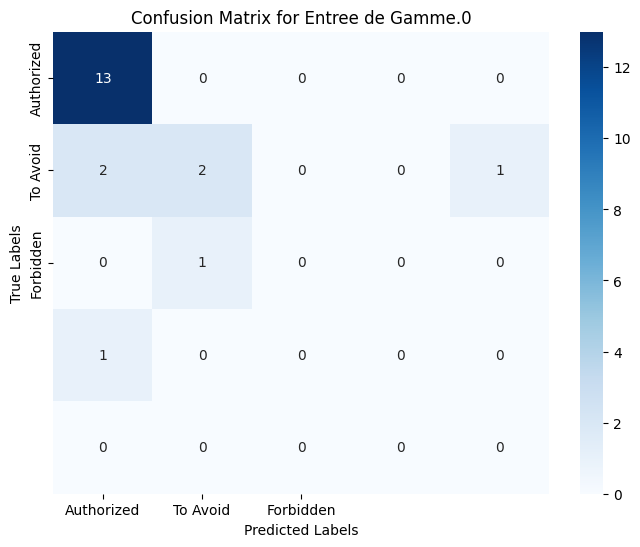

Accuracy: 75.00%
             Precision  Recall
Authorized    0.812500     1.0
To Avoid      0.666667     0.4
 To Avoid     0.000000     0.0
 Authorized   0.000000     0.0
Forbidden     0.000000     0.0

Overall Metrics:

Metrics for Coeur de Gamme.0:


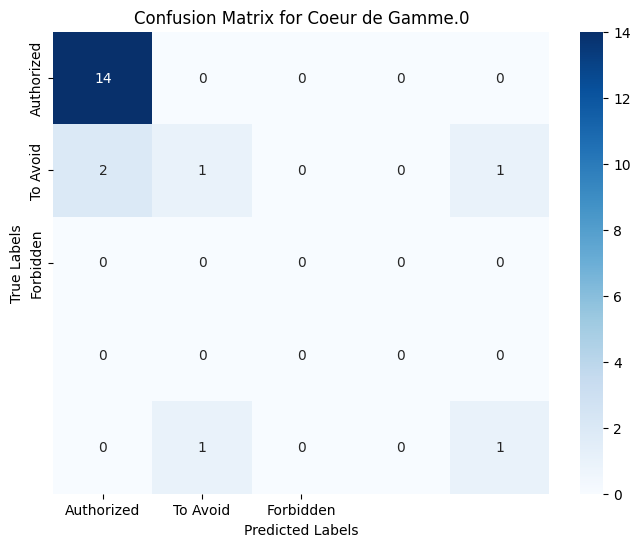

Accuracy: 80.00%
             Precision  Recall
Authorized       0.875    1.00
To Avoid         0.500    0.25
 To Avoid        0.000    0.00
 Authorized      0.000    0.00
Forbidden        0.500    0.50

Overall Metrics:

Metrics for Haut de Gamme.0:


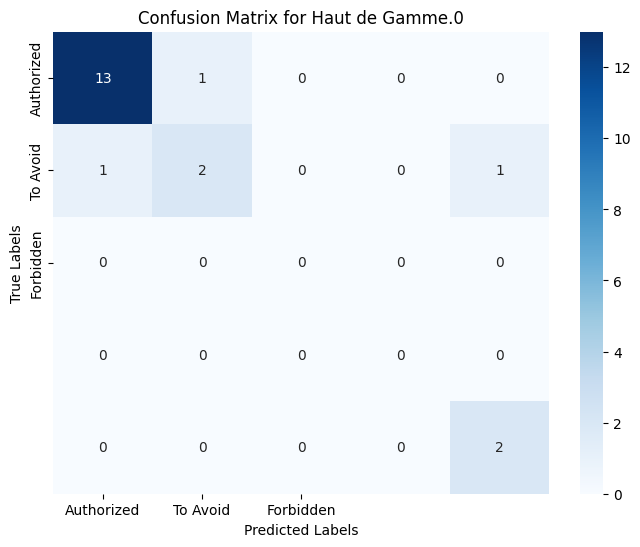

Accuracy: 85.00%
             Precision    Recall
Authorized    0.928571  0.928571
To Avoid      0.666667  0.500000
 To Avoid     0.000000  0.000000
 Authorized   0.000000  0.000000
Forbidden     0.666667  1.000000

Overall Metrics:


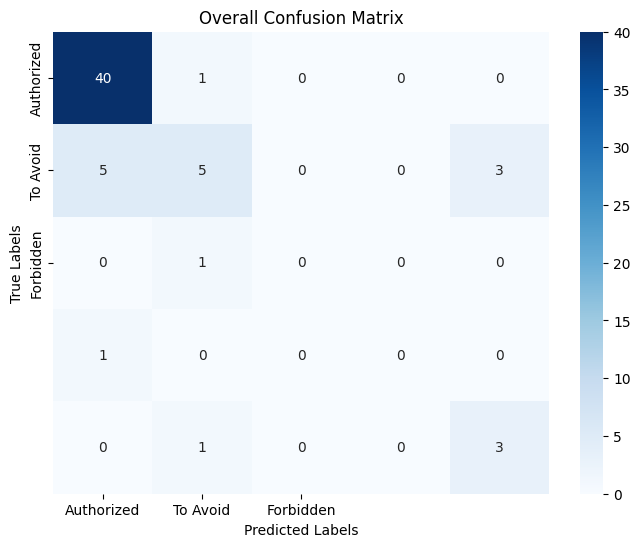

Overall Accuracy: 80.00%
             Precision    Recall
Authorized    0.869565  0.975610
To Avoid      0.625000  0.384615
 To Avoid     0.000000  0.000000
 Authorized   0.000000  0.000000
Forbidden     0.500000  0.750000


In [46]:
agent.display_metrics(metrics, overall_metrics)

In [10]:
target_df_copy

,name,Entree de Gamme,Coeur de Gamme,Haut de Gamme,cleaned_name
0,lait de chèvre pasteurisé,Authorized,Authorized,Authorized,lait de chvre pasteuris
1,sel,Authorized,Authorized,Authorized,sel
2,farine de blé,Authorized,Authorized,Authorized,farine de bl
3,beurre doux,Authorized,Authorized,Authorized,beurre doux
4,carraghénanes,To Avoid,To Avoid,To Avoid,carraghnanes
5,abricot sec,Authorized,Authorized,Authorized,abricot sec
6,E220,To Avoid,To Avoid,To Avoid,e220
7,eau,Authorized,Authorized,Authorized,eau
8,oeuf entier,To Avoid,To Avoid,To Avoid,oeuf entier
9,farine de riz,Authorized,Authorized,Authorized,farine de riz
